<a href="https://colab.research.google.com/github/JScottLopez/mlb/blob/main/MLB_Pitch_Types.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Title: MLB Pitch Classification

Authored By: Joseph Scott Lopez
Date: 8/19/2022

Description:

This notebook compares two classification algorithms using pitching data from MLB pitcher Joe Musgrove. The first is the Naive Bayes algorithm followed by K-Means Clustering.


In [24]:
#Install necessary packages
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
base = importr('base')
utils = importr('utils')

import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

packnames = ('moments','ggpubr','NbClust','factoextra','caret','e1071')

In [25]:
#Import dataset
%%R
library(readr);
Joe_Musgrove <- read_csv("Joe_Musgrove.csv")

New names:
• `vs Avg` -> `vs Avg...8`
• `vs Avg` -> `vs Avg...11`
Rows: 41 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Pitch, Team, Hand
dbl (9): Year, #, MPH, Inches of Drop, vs Avg...8, % vs Avg, Inches of Break...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [27]:
%%R
head(Joe_Musgrove)

# A tibble: 6 × 12
   Year Pitch   Team  Hand    `#`   MPH `Inches of Drop` `vs Avg...8` `% vs Avg`
  <dbl> <chr>   <chr> <chr> <dbl> <dbl>            <dbl>        <dbl>      <dbl>
1  2016 Change…  HOU  R        82  82.9             36.7          7.1         24
2  2016 Curveb…  HOU  R        77  78.6             59.7          5.9         11
3  2016 4-Seam…  HOU  R       396  92.4             19.4         -5.4        -38
4  2016 Sinker   HOU  R        75  90.6             27.6          7.4         37
5  2016 Slider   HOU  R       349  82.3             43.8          6.5         18
6  2017 Slider   HOU  R       484  83.2             42.1          4.7         12
# … with 3 more variables: `Inches of Break` <dbl>, `vs Avg...11` <dbl>,
#   `% Break vs Avg` <dbl>


In [31]:
%%R
#Assign values to system variables and check for N/A's and if they are numeric
mph<-Joe_Musgrove$MPH;
inches_drop<-Joe_Musgrove$'Inches of Drop'
inches_break<-Joe_Musgrove$'Inches of Break'

array([10.5,  9.4,  4.4, 10.9, 11.8,  9.8, 13. ,  6.2, 13.1,  1.6,  7.9,
        3.2, 10.5,  9.7,  5.6,  6.3,  4.5,  7.1,  3.1,  6.9,  5.2, 11.6,
       10.6, 10.7,  2.7, 13.5, 11.3,  5.6, 13.1, 11. ,  1.7, 14. , 10.5,
        9.2,  5. ,  4.3, 10.6, 12.7,  1.5,  8.8, 13.1])

In [30]:
%%R
#Calculate descriptive statistics for mph
summary(mph)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  78.60   82.90   87.10   87.29   92.00   93.50 


In [33]:
%%R
summary(inches_drop)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.40   25.20   31.50   33.71   41.50   59.70 


In [ ]:
%%R
summary(inches_break)

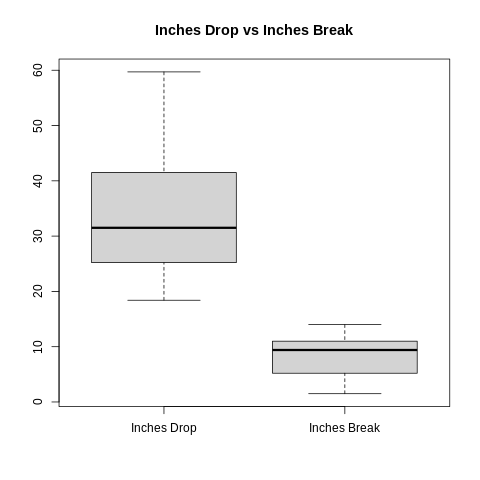

In [35]:
%%R
boxplot(inches_drop,inches_break, main="Inches Drop vs Inches Break", names=c("Inches Drop","Inches Break"))

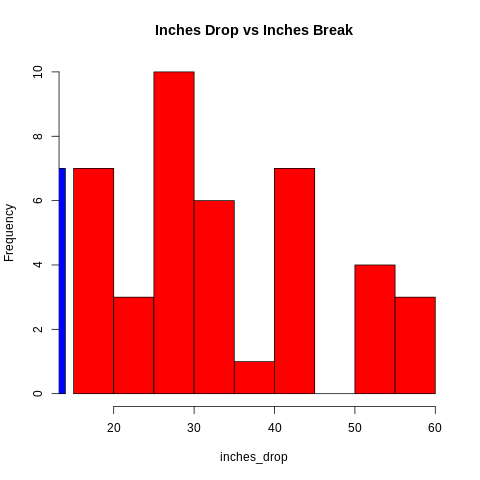

In [37]:
%%R
hist(inches_drop, col='red', main="Inches Drop vs Inches Break")
hist(inches_break, col='blue', add=TRUE)

In [39]:
%%R
inches_drop_d<-density(inches_drop)
inches_break_d<-density(inches_break)

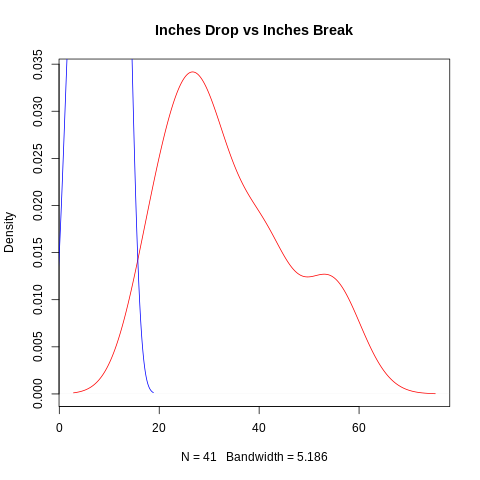

In [40]:
%%R
plot(inches_drop_d, col='red', main="Inches Drop vs Inches Break")
lines(inches_break_d, col='blue')